# ISM-FLOW Workshop 2: Analysis of Unknown Vela Clusters

This notebook applies the SigMA clustering algorithm to the vela_unknown.csv dataset, using the same analysis pipeline as Vela_clusters.ipynb.

### Used Gaia query:

SELECT * FROM gaiadr3.gaia_source <br>
WHERE (1000./parallax*COS(l*PI()/180)*COS(b*PI()/180)) > 100 <br>
AND   (1000./parallax*COS(l*PI()/180)*COS(b*PI()/180)) < 250 <br>
AND   (1000./parallax*SIN(l*PI()/180)*COS(b*PI()/180)) > -500 <br>
AND   (1000./parallax*SIN(l*PI()/180)*COS(b*PI()/180)) < -400 <br>
AND   (1000./parallax*SIN(b*PI()/180))                 > -25 <br>
AND   (1000./parallax*SIN(b*PI()/180))                 <  50 <br>
AND   parallax_over_error > 4.5

### Modules + setup

In [25]:
# robust import setup (ohne starre parents[1])
import sys, pathlib

start = pathlib.Path.cwd()
repo = None
for up in [start, *start.parents]:
    if (up/'coordinate_transformations'/'sky_convert.py').exists() \
       or (up/'SigMA'/'coordinate_transformations'/'sky_convert.py').exists():
        repo = up
        break
assert repo, "Repo-Root mit (SigMA/)coordinate_transformations nicht gefunden."

# in sys.path eintragen (nur 1x)
p = str(repo)
if p not in sys.path:
    sys.path.insert(0, p)

# Import-Cache leeren falls vorher falscher Pfad geladen wurde
for m in list(sys.modules):
    if m.startswith(('coordinate_transformations','SigMA')):
        sys.modules.pop(m)
        
print("Import OK from repo:", repo)

Import OK from repo: /Users/laxman/projects/GitHub/Distant_SigMA


## Loading and preparing the data

Load the vela_unknown.csv file and transform to Galactic cartesian coordinates.

In [26]:
# Python modules
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time, datetime
from sklearn.preprocessing import LabelEncoder

# SigMA modules
from coordinate_transformations.sky_convert import transform_sphere_to_cartesian
from SigMA.SigMA import SigMA
from sklearn.metrics import normalized_mutual_info_score as nmi

#### DistantSigMA modules
from DistantSigMA.DistantSigMA.clustering_routine import *
from DistantSigMA.DistantSigMA.PlotlyResults import plot
from DistantSigMA.DistantSigMA.cluster_simulations import calculate_std_devs
from DistantSigMA.DistantSigMA.scalefactor_sampling import lhc_lloyd

# Paths
output_path = "output/"
if not os.path.exists(output_path):
    os.makedirs(output_path)

In [27]:
# Load the vela_unknown data
df_raw = pd.read_csv("vela_unkown.csv", 
                      usecols=['ra', 'dec', 'parallax', 'pmra', 'pmdec', 'radial_velocity', 'radial_velocity_error'])

print(f"Loaded {len(df_raw)} stars from vela_unknown.csv")
print(f"Columns: {df_raw.columns.tolist()}")
df_raw.head()

Loaded 3459 stars from vela_unknown.csv
Columns: ['ra', 'dec', 'parallax', 'pmra', 'pmdec', 'radial_velocity', 'radial_velocity_error']


,ra,dec,parallax,pmra,pmdec,radial_velocity,radial_velocity_error
0,160.389234,-62.005536,2.160151,-9.885377,1.994156,9.682576,3.073550
1,159.363013,-61.363109,2.229125,-7.124699,4.600866,NaN,NaN
2,160.421657,-62.295294,2.301684,-23.883279,-0.903131,35.985104,3.176580
3,159.346009,-61.340433,2.155335,-5.732393,-2.202260,-0.757232,4.590215
4,159.188661,-61.862679,2.360172,-7.394753,6.498764,20.437298,4.982596


In [28]:
# Transform to Galactic cartesian coordinates
xyz = transform_sphere_to_cartesian(ra=df_raw.ra.to_numpy(), 
                                     dec=df_raw.dec.to_numpy(), 
                                     parallax=df_raw.parallax.to_numpy(),
                                     pmra=df_raw.pmra.to_numpy(),
                                     pmdec=df_raw.pmdec.to_numpy())

# Combine with original data
df = pd.concat([df_raw, xyz], axis=1)
df["distance"] = 1000 / df_raw['parallax']

print(f"Transformed coordinates. Distance range: {df.distance.min():.1f} - {df.distance.max():.1f} pc")
df.head()

Transformed coordinates. Distance range: 415.0 - 558.2 pc


,ra,dec,parallax,pmra,pmdec,radial_velocity,radial_velocity_error,X,Y,Z,v_a_lsr,v_d_lsr,distance
0,160.389234,-62.005536,2.160151,-9.885377,1.994156,9.682576,3.073550,145.307396,-438.919854,-23.233904,-5.793231,3.494787,462.930547
1,159.363013,-61.363109,2.229125,-7.124699,4.600866,NaN,NaN,135.356961,-427.232506,-19.967923,0.661064,8.748746,448.606553
2,160.421657,-62.295294,2.301684,-23.883279,-0.903131,35.985104,3.176580,137.434177,-411.473787,-23.677360,-33.286190,-2.776393,434.464553
3,159.346009,-61.340433,2.155335,-5.732393,-2.202260,-0.757232,4.590215,139.851866,-441.909247,-20.524249,3.203098,-5.879862,463.965054
4,159.188661,-61.862679,2.360172,-7.394753,6.498764,20.437298,4.982596,129.016186,-402.956851,-22.371536,0.944505,11.899841,423.697870


Total stars in dataset: 3459
Distance range: 415.0 - 558.2 pc


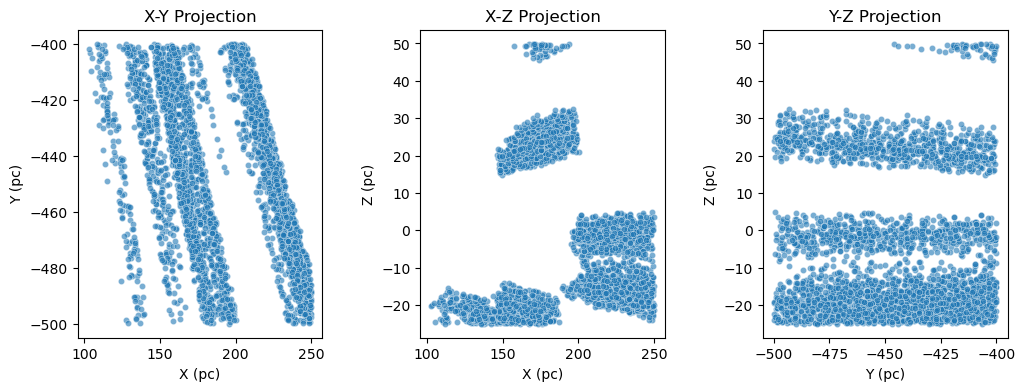

In [23]:
# Use the full dataset (no distance restriction)
df_near = df.copy()
print(f"Total stars in dataset: {len(df_near)}")
print(f"Distance range: {df_near.distance.min():.1f} - {df_near.distance.max():.1f} pc")

# Plot the spatial distribution
f, ax = plt.subplots(1, 3, figsize=(12, 4))

sns.scatterplot(data=df_near, x="X", y="Y", ax=ax[0], s=20, alpha=0.6)
ax[0].set_title("X-Y Projection")
ax[0].set_xlabel("X (pc)")
ax[0].set_ylabel("Y (pc)")

sns.scatterplot(data=df_near, x="X", y="Z", ax=ax[1], s=20, alpha=0.6)
ax[1].set_title("X-Z Projection")
ax[1].set_xlabel("X (pc)")
ax[1].set_ylabel("Z (pc)")

sns.scatterplot(data=df_near, x="Y", y="Z", ax=ax[2], s=20, alpha=0.6)
ax[2].set_title("Y-Z Projection")
ax[2].set_xlabel("Y (pc)")
ax[2].set_ylabel("Z (pc)")

plt.subplots_adjust(wspace=0.4)
plt.show()

## Setting up velocity scaling

Load the velocity scaling factors from the Bayesian model trained on Vela.

In [7]:
# Load velocity scaling information from Bayesian model
from SigMA.bayesian_velocity_scaling import scale_factors as sf_function

vel_scaling_info = np.load('bayesian_LR_data.npz')
x_sf, post_pred_sf = vel_scaling_info['x'], vel_scaling_info['posterior_predictive']

# Generate scale factor list based on distance range
scale_factor_list = sf_function(x_sf, post_pred_sf, 
                                 x_range=(df_near.distance.min(), df_near.distance.max()))
sf_mean = np.mean(scale_factor_list)

print(f"Velocity scale factors: {scale_factor_list}")
print(f"Mean scale factor: {sf_mean:.4f}")

/Users/laxman/projects/GitHub/Distant_SigMA/SigMA/bayesian_velocity_scaling.py:36: RuntimeWarning: invalid value encountered in divide
  x = x / np.sum(x)


ValueError: Input X contains NaN.
NearestNeighbors does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [8]:
# Define clustering features (Galactic cartesian coordinates)
cluster_features = ['X', 'Y', 'Z', 'v_a_lsr', 'v_d_lsr']
print(f"Clustering features: {cluster_features}")

Clustering features: ['X', 'Y', 'Z', 'v_a_lsr', 'v_d_lsr']


## 1. Basic SigMA Clustering

Start with basic clustering using a single KNN value and mean velocity scale factor.

In [9]:
# Parameters
knn = 100
alpha = 0.05
bh_correction = True

# Fixed parameters
beta = 0.99
knn_initcluster_graph = 30

sigma_kwargs = dict(
    cluster_features=cluster_features,
    scale_factors={'vel': {'features': ['v_a_lsr', 'v_d_lsr'], 'factor': sf_mean}},
    nb_resampling=0,
    max_knn_density=knn+1,
    beta=beta,
    knn_initcluster_graph=knn_initcluster_graph,
)

print(f"SigMA parameters:")
print(f"  KNN: {knn}")
print(f"  Alpha (significance level): {alpha}")
print(f"  Velocity scale factor: {sf_mean:.4f}")

NameError: name 'sf_mean' is not defined

In [10]:
%%time
# Initialize and fit SigMA
clusterer = SigMA(data=df_near, **sigma_kwargs)

st = time.time()
print('Starting clustering...')
clusterer.fit(alpha=alpha, knn=knn, bh_correction=bh_correction)
labels = clusterer.labels_

delta_t = str(datetime.timedelta(seconds=time.time() - st)).split('.')[0]
print(f'Done! [took {delta_t}]. Found {np.unique(labels).size} clusters')

# Save point-wise density
rho = clusterer.weights_

# Encode labels to 0-(N-1)
ln = LabelEncoder().fit_transform(labels)
df_near["SigMA_label"] = ln

CPU times: user 7 μs, sys: 0 ns, total: 7 μs
Wall time: 7.87 μs


NameError: name 'sigma_kwargs' is not defined

In [11]:
# View the basic clustering results
plot(labels=ln, df=df_near, filename="Vela_Unknown_Basic", output_pathname=output_path)

# Visualize in 3D space
f, ax = plt.subplots(1, 3, figsize=(12, 4))

sns.scatterplot(data=df_near, x="X", y="Y", hue="SigMA_label", palette="tab10", ax=ax[0])
ax[0].set_title("SigMA Clusters - X-Y Projection")
ax[0].set_xlabel("X (pc)")
ax[0].set_ylabel("Y (pc)")

sns.scatterplot(data=df_near, x="X", y="Z", hue="SigMA_label", palette="tab10", ax=ax[1])
ax[1].set_title("SigMA Clusters - X-Z Projection")
ax[1].set_xlabel("X (pc)")
ax[1].set_ylabel("Z (pc)")

sns.scatterplot(data=df_near, x="Y", y="Z", hue="SigMA_label", palette="tab10", ax=ax[2])
ax[2].set_title("SigMA Clusters - Y-Z Projection")
ax[2].set_xlabel("Y (pc)")
ax[2].set_ylabel("Z (pc)")

plt.subplots_adjust(wspace=0.4)
plt.show()

print(f"Number of clusters found: {ln.max() + 1}")
print(f"Stars in clusters: {(ln != -1).sum()}")
print(f"Field stars: {(ln == -1).sum()}")

NameError: name 'ln' is not defined

## 2. Consensus Clustering

Perform consensus clustering using multiple KNN values and velocity scaling factors to obtain more robust results.

In [12]:
def consensus_function(label_matrix: np.array, density_sum: np.array, df_fit: pd.DataFrame, 
                       file: str = None, path: str = None, plotting: bool = True, field_comp: bool = True):
    """
    Function that takes the different labels created in a loop over either KNNs or scaling factors 
    and makes a consensus solution.

    :param label_matrix: matrix holding the different results of the loop
    :param density_sum: the sum of the 1D density calculated in each step of the loop
    :param df_fit: input dataframe
    :param file: filename for the plot
    :param path: output path of the plot
    :param plotting: bool
    :return: consensus-labels and number of clusters found in the consensus solution
    """
    cc = ClusterConsensus(*label_matrix)
    labels_cc = cc.fit(density=density_sum, min_cluster_size=15)
    if field_comp:
        labels_cc_clean = LabelEncoder().fit_transform(labels_cc)-1
    else:
        labels_cc_clean = LabelEncoder().fit_transform(labels_cc)

    if plotting:
        plot(labels=labels_cc_clean, df=df_fit, filename=file, output_pathname=path)
    nb_consensus = np.unique(labels_cc_clean[labels_cc_clean > -1]).size

    return labels_cc_clean, nb_consensus

In [13]:
# Consensus clustering parameters
KNNs = [50, 100, 200]
a = 0.01
bh_corr = True

sigma_kwargs = dict(
    cluster_features=['X', 'Y', 'Z', 'v_a_lsr', 'v_d_lsr'],
    scale_factors={'vel': {'features': ['v_a_lsr', 'v_d_lsr'], 'factor': sf_mean}},
    nb_resampling=0,
    max_knn_density=max(KNNs) + 1,
    beta=0.99,
    knn_initcluster_graph=35)

print(f"Consensus clustering parameters:")
print(f"  KNNs: {KNNs}")
print(f"  Alpha: {a}")
print(f"  Number of velocity scale factors: {len(scale_factor_list)}")

NameError: name 'sf_mean' is not defined

In [14]:
%%time
# Initialize SigMA
clusterer = SigMA(data=df_near, **sigma_kwargs)

# Initialize arrays for collecting results
rhosum_list = []
results = np.empty(shape=(len(KNNs), len(df_near)))

# Outer loop: KNN
for kid, knn in enumerate(KNNs):
    print(f"\n{'='*60}")
    print(f"Current run with KNN = {knn}")
    print(f"{'='*60}\n")

    # Initialize arrays for inner loop
    label_matrix = np.empty(shape=(len(scale_factor_list), len(df_near)))
    rho_sum = np.zeros(df_near.shape[0], dtype=np.float32)

    # Inner loop: Scale factors
    for sf_id, sf in enumerate(scale_factor_list):
        scale_factors = {'vel': {'features': ['v_a_lsr', 'v_d_lsr'], 'factor': sf}}
        clusterer.set_scaling_factors(scale_factors)
        print(f"  Clustering with scale factor {sf:.4f}...", end=" ")

        # Fit
        clusterer.fit(alpha=a, knn=knn, bh_correction=bh_corr)
        label_array = clusterer.labels_
        label_matrix[sf_id, :] = label_array

        # Accumulate density
        rho = clusterer.weights_
        rho_sum += rho
        print("Done")

    rhosum_list.append(rho_sum)

    # Perform inner consensus clustering (ICC)
    labels_icc, n_icc = consensus_function(label_matrix, rho_sum, df_near,
                                          f"KNN_{knn}_ICC_plot", output_path,
                                          plotting=True, field_comp=False)
    results[kid, :] = labels_icc
    print(f"\n:: Finished KNN={knn}! Found {n_icc} final clusters.\n")

# Perform outer consensus clustering (OCC)
knn_mid = int(len(KNNs) / 2 - 1)  # Mean density is chosen for outer consensus
df_save = df_near.copy()

labels_occ, n_occ = consensus_function(results, rhosum_list[knn_mid], df_near, 
                                      f"OCC_plot", output_path, field_comp=False)

df_save["labels_final"] = labels_occ
print(f"\n{'='*60}")
print(f"CONSENSUS CLUSTERING COMPLETE")
print(f"Final number of clusters: {n_occ}")
print(f"{'='*60}")

CPU times: user 11 μs, sys: 0 ns, total: 11 μs
Wall time: 13.8 μs


NameError: name 'sigma_kwargs' is not defined

NameError: name 'df_save' is not defined

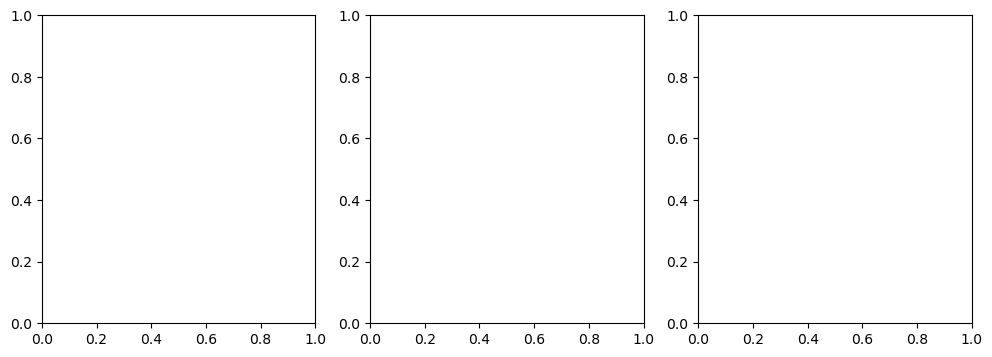

In [15]:
# Visualize consensus clustering results
f, ax = plt.subplots(1, 3, figsize=(12, 4))

sns.scatterplot(data=df_save, x="X", y="Y", hue="labels_final", palette="tab10", ax=ax[0])
ax[0].set_title("Consensus Clusters - X-Y Projection")
ax[0].set_xlabel("X (pc)")
ax[0].set_ylabel("Y (pc)")

sns.scatterplot(data=df_save, x="X", y="Z", hue="labels_final", palette="tab10", ax=ax[1])
ax[1].set_title("Consensus Clusters - X-Z Projection")
ax[1].set_xlabel("X (pc)")
ax[1].set_ylabel("Z (pc)")

sns.scatterplot(data=df_save, x="Y", y="Z", hue="labels_final", palette="tab10", ax=ax[2])
ax[2].set_title("Consensus Clusters - Y-Z Projection")
ax[2].set_xlabel("Y (pc)")
ax[2].set_ylabel("Z (pc)")

plt.subplots_adjust(wspace=0.4)
plt.show()

print(f"Number of clusters found: {df_save.labels_final.max() + 1}")
print(f"Stars in clusters: {(df_save.labels_final != -1).sum()}")
print(f"Field stars: {(df_save.labels_final == -1).sum()}")

## 3. Save Results

Save the clustering results to CSV for further analysis.

In [17]:
# Save results to CSV
output_file = "vela_unknown_clustering_results.csv"
df_save.to_csv(output_file, index=False)
print(f"Results saved to {output_file}")

# Print summary statistics
print(f"\nClustering Summary:")
print(f"{'='*60}")
print(f"Total stars analyzed: {len(df_save)}")
print(f"Distance range: {df_save.distance.min():.1f} - {df_save.distance.max():.1f} pc")
print(f"Number of clusters: {(df_save.labels_final >= 0).sum() > 0 and df_save.labels_final.max() + 1}")
print(f"Clustered stars: {(df_save.labels_final >= 0).sum()}")
print(f"Field stars: {(df_save.labels_final == -1).sum()}")

# Print cluster sizes
cluster_sizes = df_save[df_save.labels_final >= 0].groupby('labels_final').size()
print(f"\nCluster sizes:")
for cluster_id, size in cluster_sizes.items():
    print(f"  Cluster {int(cluster_id)}: {size} stars")

NameError: name 'df_save' is not defined